In [1]:
import torch

from pytorch_lightning import Trainer

from models.configurations import TEXT_PRETRAINED, VISION_PRETRAINED
from models.finetuner import AdaptorFinetuner
from models.segmenter import AdaptorSegmenter
from models.adaptor import Adaptor
from utils.model_utils import get_newest_ckpt
from dataset.dataset import clf_collator
from dataset.configurations import DATASET_CFG
from dataset.data_module import AdaptorDataModule#
from utils.model_utils import load_vision_model

import numpy as np

In [2]:
task = "clf"
vision_model = "dinov2-b"
text_model = "bert"
# dataset = "rsna"
# dataset = "siim"
dataset = "covidx"

vision_model_config = VISION_PRETRAINED[vision_model]
vision_pretrained = vision_model_config["pretrained_weight"]
vision_model_type = vision_model_config["vision_model_type"]

dataset_cfg = DATASET_CFG["clf"][dataset]
# dataset_cfg = DATASET_CFG["seg"][dataset]
dataset_class = dataset_cfg["class"]
dataset_kwargs = dataset_cfg["kwargs"]
data_transform = vision_model_config["data_transform"]

data_module = AdaptorDataModule(
    dataset=dataset_class,
    collate_fn=clf_collator,
    transforms=data_transform,
    data_pct=1.0,
    batch_size=16,
    num_workers=1,
    crop_size=224,
    seed=1117,
    **dataset_kwargs,
)
data_module.setup(stage="test")

test_dataset = data_module.datasets['test']#.shuffle(seed=42)
loader = torch.utils.data.DataLoader(test_dataset, batch_size=data_module.batch_size, num_workers=1, collate_fn=clf_collator)

In [3]:
import os
task = "clf"

models_dir = f"/vol/bitbucket/jq619/adaptor-thesis/trained_models/{task}/{vision_model}_{text_model}_{dataset}_1.0/adaptor_finetune_v3_covidx/"
ckpt_dir = os.path.join(models_dir, os.listdir(models_dir)[0], "checkpoints")
model_ckpt = os.path.join(ckpt_dir, os.listdir(ckpt_dir)[0])

In [4]:
adaptor_ckpt = get_newest_ckpt(
    vision_model, text_model, postfix="v3", 
    project_name="adaptor_pretrain_v3", 
)

adaptor = Adaptor.load_from_checkpoint(adaptor_ckpt)
backbone = load_vision_model(
    vision_model_type=vision_model_type,
    vision_pretrained=vision_pretrained,
    retain_head=False,
)
model = AdaptorFinetuner.load_from_checkpoint(
    model_ckpt, 
    backbone=backbone,
    adaptor=adaptor,
)

# model = AdaptorSegmenter(
#     seg_model=backbone,
#     adaptor=adaptor,
# # )

# model = AdaptorSegmenter.load_from_checkpoint()

model.linear_layer = torch.nn.Identity()
model.eval()

Using cache found in /homes/jq619/.cache/torch/hub/facebookresearch_dinov2_main
xFormers not available
xFormers not available


AdaptorFinetuner(
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
  (backbone): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0): NestedTensorBlock(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate=none)
          (fc2): Linear(in_fe

In [5]:
from tqdm import tqdm
from math import ceil


n_samples = 400
total_steps = ceil(n_samples//data_module.batch_size)
i = 0

print(total_steps)

pre_adaptor_embeddings_list = [] 
embeddings_list = []
labels_list = []
prediction_list = []

# Ensure no gradients are computed
with torch.no_grad():
    for batch_idx, batch in tqdm(enumerate(loader), total=total_steps):
        if i == total_steps:
            break
        # Extract data from batch (depends on your data format)
        inputs, labels = batch['pixel_values'], batch['labels']
        # Move inputs to device (GPU if available)
        inputs = inputs.to(model.device)
        # Get embeddings
        pre_adaptor_embeddings = model.backbone(inputs)
        embeddings = model.adaptor(pre_adaptor_embeddings)
        pred = torch.argmax(linear_layer(embeddings), dim=1, keepdim=True).float()
        # Convert embeddings to numpy and store
        pre_adaptor_embeddings_list.append(pre_adaptor_embeddings.cpu().numpy())
        embeddings_list.append(embeddings.cpu().numpy())
        labels_list.append(labels.cpu().numpy())
        prediction_list.append(pred.cpu().numpy())
        
        i += 1

100


 25%|██▌       | 25/100 [05:04<15:13, 12.18s/it]


In [6]:
all_pre_adaptor_embeddings = np.concatenate(pre_adaptor_embeddings_list, axis=0)
all_embeddings = np.concatenate(embeddings_list, axis=0)
labels = np.concatenate(labels_list, axis=0)
predictions = np.concatenate(prediction_list, axis=0)


# Save embeddings to .npy file
test_embeds_dir = 'test_embeds'
!mkdir $test_embeds_dir
np.save(os.path.join(test_embeds_dir, 'embeddings.npy'), all_embeddings)
np.save(os.path.join(test_embeds_dir, 'labels.npy'), labels)
np.save(os.path.join(test_embeds_dir, 'predictions.npy'), predictions)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.001s...
[t-SNE] Computed neighbors for 400 samples in 1.010s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 0.290864
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.749870
[t-SNE] KL divergence after 950 iterations: 0.791040
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.000s...
[t-SNE] Computed neighbors for 400 samples in 0.264s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 3.605065
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.224285
[t-SNE] KL divergence after 1000 iterations: 0.998873
Shape of tsne_results: (400, 2)
Shape of raw_tsne_results: (400, 2)
Shape of labels: (400, 1)


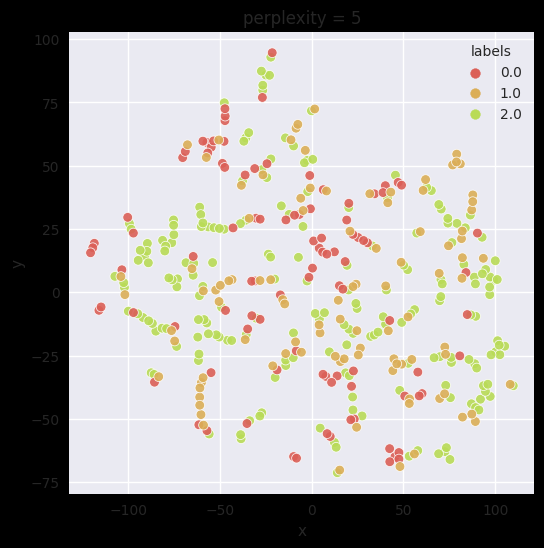

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.000s...
[t-SNE] Computed neighbors for 400 samples in 0.193s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 0.312544
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.732010
[t-SNE] KL divergence after 5000 iterations: 1.416770


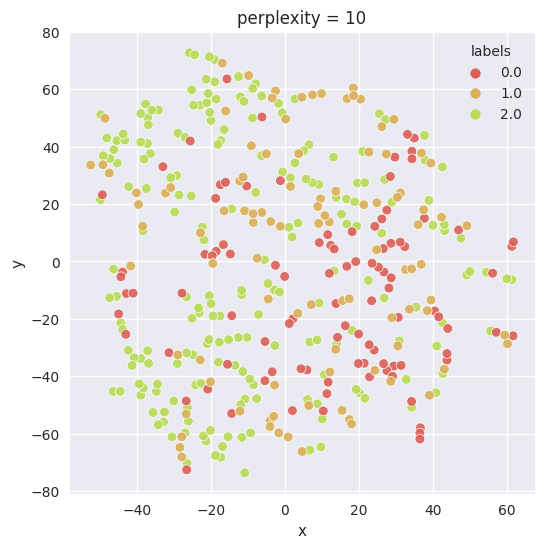

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.000s...
[t-SNE] Computed neighbors for 400 samples in 0.203s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 0.352283
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.729210
[t-SNE] KL divergence after 4000 iterations: 1.425746


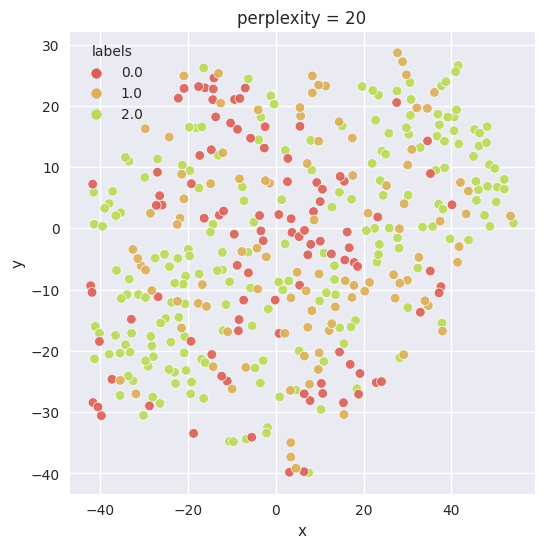

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.000s...
[t-SNE] Computed neighbors for 400 samples in 0.182s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 0.372622
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.003208
[t-SNE] KL divergence after 2000 iterations: 1.339564


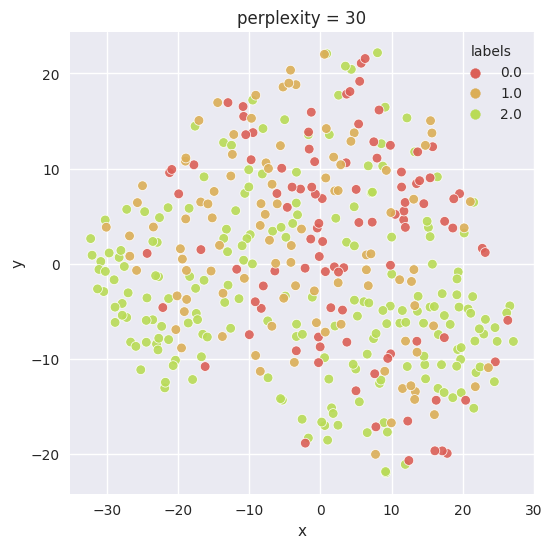

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.001s...
[t-SNE] Computed neighbors for 400 samples in 0.204s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 0.386287
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.644218
[t-SNE] KL divergence after 2150 iterations: 1.246136


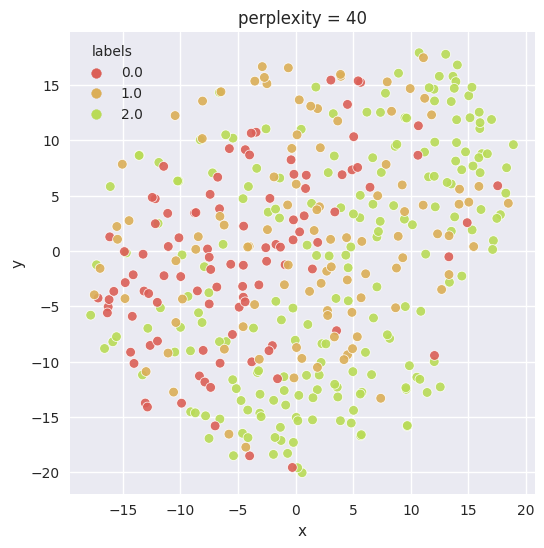

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.000s...
[t-SNE] Computed neighbors for 400 samples in 0.207s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 0.396684
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.039204
[t-SNE] KL divergence after 2500 iterations: 1.208990


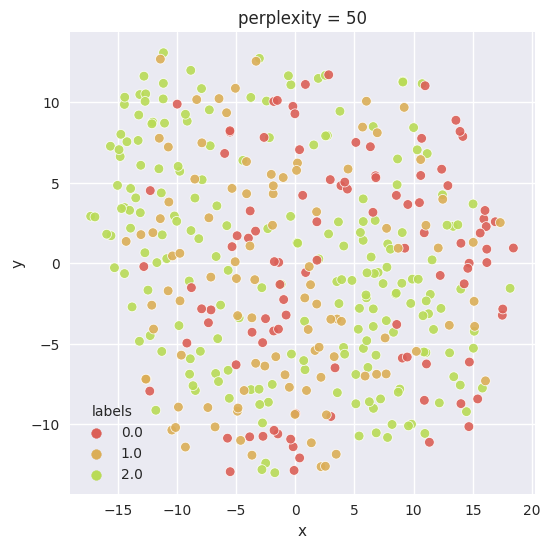

In [7]:
# With PCA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np

def apply_pca_then_tsne(data, n_pca_components=50, perplexity=40, n_iter=1000, random_state=1024):
    # Apply PCA first
    pca = PCA(n_components=n_pca_components, random_state=random_state)
    pca_result = pca.fit_transform(data)
    
    # Then apply t-SNE
    tsne = TSNE(n_components=2, random_state=random_state, verbose=1, perplexity=perplexity, n_iter=n_iter)
    tsne_result = tsne.fit_transform(pca_result)
    
    return tsne_result

# Apply PCA then t-SNE on all embeddings
tsne_results = apply_pca_then_tsne(all_embeddings)

# Apply PCA then t-SNE on all pre-adaptor embeddings
raw_tsne_results = apply_pca_then_tsne(all_pre_adaptor_embeddings)

print(f"Shape of tsne_results: {tsne_results.shape}")
print(f"Shape of raw_tsne_results: {raw_tsne_results.shape}")
print(f"Shape of labels: {labels.shape}")

In [8]:
# Combine results into a DataFrame
tsne_df = pd.DataFrame({
    'x': tsne_results[:, 0],
    'y': tsne_results[:, 1],
    'x_raw': raw_tsne_results[:, 0],
    'y_raw': raw_tsne_results[:, 1],
    'labels': np.vectorize({0: 'Normal', 1: 'Pneumonia', 2: 'COVID-19'}.get)(labels.flatten())
})

# Check if the DataFrame was created successfully
print(tsne_df.head())
    

           x          y     x_raw      y_raw    labels
0   0.531526   1.457799 -9.053300   7.819124  COVID-19
1  13.086493  11.281870 -6.554493 -12.768573  COVID-19
2  -2.203901  -1.071111 -5.774090   7.344403  COVID-19
3  -2.698989   3.043940 -7.401220   0.812468  COVID-19
4  -1.229403  -0.631816 -7.614432   5.788849  COVID-19


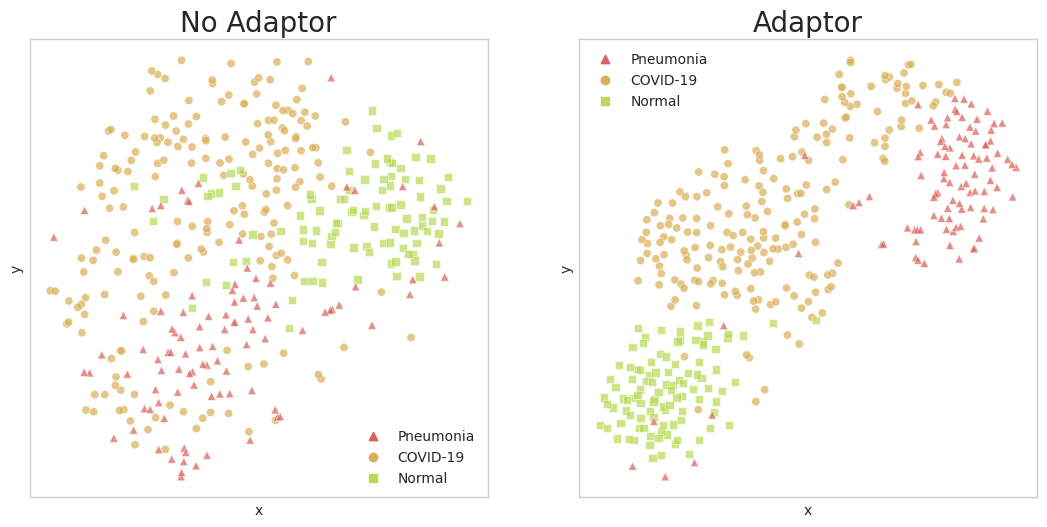

In [12]:
plt.style.use('seaborn-whitegrid')

markers = ["o", "s", "^"]  # Circle for Pneumonia, Square for COVID-19, and Triangle for Normal

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(13, 6))

ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("No Adaptor", fontsize=20)
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("Adaptor", fontsize=20)
ax[1].set_xticks([])
ax[1].set_yticks([])

sns.scatterplot(
    x="x_raw", y="y_raw",
    hue="labels",
    hue_order=["Pneumonia", "COVID-19", "Normal"],
    palette=sns.color_palette("hls", 10),
    data=tsne_df,
    legend="full",
    alpha=0.7, 
    ax=ax[0],
    style="labels",  # Add this line
    markers=markers  # And this line
)

sns.scatterplot(
    x="x", y="y",
    hue="labels",
    hue_order=["Pneumonia", "COVID-19", "Normal"],
    palette=sns.color_palette("hls", 10),
    data=tsne_df,
    legend="full",
    alpha=0.7, 
    ax=ax[1],
    style="labels",  # Add this line
    markers=markers  # And this line
)


ax[0].legend().set_label("")
ax[1].legend().set_label("")

ax[0].set_aspect(1.0/ax[0].get_data_ratio(), 'box')
ax[1].set_aspect(1.0/ax[1].get_data_ratio(), 'box')

plt.savefig("figs/embeddings_tsne.png", dpi=300, facecolor='white', bbox_inches='tight')

In [62]:
import numpy as np
from scipy.stats import entropy

def compute_average_entropy(feature_matrix, n_bins=100):
    """
    Compute the average entropy across all features in the feature matrix.
    
    Parameters:
    - feature_matrix (np.ndarray): An array of shape (num_samples, num_features)
    
    Returns:
    - float: average entropy across all features
    """
    num_samples, num_features = feature_matrix.shape
    average_entropy = 0
    
    # Normalize each feature
    normalized_features = (feature_matrix - np.mean(feature_matrix, axis=0)) / np.std(feature_matrix, axis=0)
    
    for i in range(num_features):
        # Compute histogram for the feature
        hist, _ = np.histogram(normalized_features[:, i], bins=n_bins, density=True)
        
        # Filter out zero values to avoid log(0)
        hist = hist[hist > 0]
        
        # Compute entropy for the feature and add to the total
        average_entropy += entropy(hist)
    
    return average_entropy / num_features

# Example usage:
feature_matrix =  all_embeddings
avg_entropy = compute_average_entropy(feature_matrix)
print(f"Average Entropy: {avg_entropy}")


Average Entropy: 4.14296558998332


In [63]:
feature_matrix =  all_pre_adaptor_embeddings
avg_entropy = compute_average_entropy(feature_matrix)
print(f"Average Entropy: {avg_entropy}")

Average Entropy: 3.944915176555805
